<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/Latihan_Neural_Network_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jcopml

     |████████████████████████████████| 102kB 4.7MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.10-py2.py3-none-any.whl size=33230 sha256=8381799c2fe4fc282cfe047d4a07fc9b09bcdfbeb323cbf92e836259a320b48a
  Stored in directory: /root/.cache/pip/wheels/82/22/ce/b8b4c3400f788e5050b5b4b4d988884b8ec72b6b8751693914
Successfully built jcopml


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pandas as pd

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_missing_value, plot_confusion_matrix, plot_correlation_matrix

device = torch.device("Cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [33]:
datas = pd.read_csv("/content/diabetes.csv")
X = datas.drop(columns='Outcome')
y = datas.Outcome.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [34]:
preprocessing = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
])

X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)
X_train

array([[1.00e+00, 9.00e+01, 6.20e+01, ..., 2.72e+01, 5.80e-01, 2.40e+01],
       [5.00e+00, 1.26e+02, 7.80e+01, ..., 2.96e+01, 4.39e-01, 4.00e+01],
       [2.00e+00, 1.05e+02, 5.80e+01, ..., 3.49e+01, 2.25e-01, 2.50e+01],
       ...,
       [1.00e+00, 9.70e+01, 7.00e+01, ..., 3.81e+01, 2.18e-01, 3.00e+01],
       [1.00e+01, 1.11e+02, 7.00e+01, ..., 2.75e+01, 1.41e-01, 4.00e+01],
       [4.00e+00, 1.44e+02, 5.80e+01, ..., 2.95e+01, 2.87e-01, 3.70e+01]])

In [35]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [36]:
train_dataset = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
testloader = DataLoader(test_dataset, batch_size=64)

In [37]:
model = nn.Sequential(
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(4, 2),
    nn.LogSoftmax(1)
).to(device)

criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [38]:
epochs = 500
train_cost, test_cost = [], []

for i in range(epochs):
  model.train()
  cost = 0
  for feature, target in trainloader:
    output = model(feature)
    loss = criterion(output, target)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    cost += loss.item()*feature.shape[0]
  train_cost.append(cost/len(train_dataset))

  with torch.no_grad():
    model.eval()
    cost = 0
    for feature, target in testloader:
      output = model(feature)
      loss = criterion(output, target)

      cost += loss.item()*feature.shape[0]
    test_cost.append(cost/len(test_dataset))
  print(f"\rEpoch {i+1}/{epochs} | Train_cost: {train_cost[-1]:.4f} | Test_cost {test_cost[-1]:.4f}", end=" ")


Epoch 500/500 | Train_cost: 0.5727 | Test_cost 0.5824 

In [39]:
import matplotlib.pyplot as plt

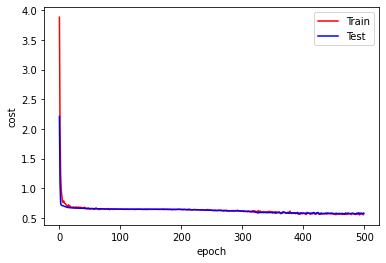

In [40]:
plt.plot(train_cost, 'r-', label='Train')
plt.plot(test_cost, 'b-', label='Test')
plt.xlabel('epoch'); plt.ylabel('cost'); plt.legend()

In [41]:
with torch.no_grad():
  model.eval()
  output = model(X_test)
  pred = output.argmax(1)
acc = (y_test == pred).to(torch.float32).mean()
acc

tensor(0.6883)